# Альтернативный подход к построению модели

Пердполагяется определиться заранее и идентификационной формой и пытаться улучшать её всеми доступными методами

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score

import torch.optim as optim

import matplotlib.pyplot as plt

from nets_algo import *

# Подготовительный этап

## Функция потерь

In [2]:
loss_fn = nn.BCELoss()

## Данные

In [3]:
data = pd.read_csv(
    "/home/dranik/KFA/university/proc_2.csv", 
    index_col = 0
)

In [4]:
Y = np.array(data[['Y']])
X = data.drop('Y', axis = 1)

X = np.concatenate([
    OneHotEncoder(sparse = False).\
    fit_transform(X.loc[:,X.dtypes == "O"]),
    X.loc[:,X.dtypes != "O"].to_numpy()
], axis = 1)

Нормализация

In [5]:
X = normalize(X)

In [6]:
X_train, X_test, y_train, y_test = \
    train_test_split(
        X,Y, random_state = 0, stratify = Y
)

Наборы данных и загрузчики данных

In [7]:
train_data = My_data_set(
    torch.tensor(X_train.astype('float32')), 
    torch.tensor(y_train.astype('float32'))
)
train_data_loader =\
torch.utils.data.DataLoader(
    train_data, batch_size=500
)

In [8]:
test_data = My_data_set(
    torch.tensor(X_test.astype('float32')), 
    torch.tensor(y_test.astype('float32'))
)
test_data_loader =\
torch.utils.data.DataLoader(
    test_data, batch_size=500
)

## Базовый алгоритм терировки модели

In [31]:
from copy import deepcopy

class model_trainer():
    '''Класс реализует алгоритм обучения сети'''
    def __init__(
        self, model, optimizer, 
        loss_fn, lr_scheduler = None
    ):
        # inputs:
        # model - модель которая подлежит обучению
        # optimizer - оптимизатор, который педполагается использовать
        # loss_fn - функция потерь
        # lr_shceduler - планировщих learning rate
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        self.train_loss = np.array([])
        self.test_loss = np.array([])
        
        # тут храним лучшую модель
        # из полученных если ошиентироваться
        # на ошибку на тестовых данных
        self.best_model = deepcopy(model)
        self.best_epoch = 0
        
        self.lr_scheduler = lr_scheduler
        
        
    def append_loses(self, train_loader, test_loader):
        '''Добавление ошибок рассчитанных
        на тренировочном и тестовом загрузчиках'''
        self.train_loss = np.append(
            self.train_loss,
            get_loss_value(
                self.loss_fn, 
                self.model, 
                train_loader
            )
        )
        self.test_loss = np.append(
            self.test_loss,
            get_loss_value(
                self.loss_fn, 
                self.model, 
                test_loader
            )
        )
        
    
    def fit(self, train_loader, test_loader,
            epochs = 20, check_epoch = 1):
        '''Провести тренировку модели'''
        # inputs:
        # train_loader - загрузчик тренировочных данных
        # test_loader - загрузчик тестовых данных
        # epochs - число эпох для обучения алгоритма
        # check_epoces - число эпох после чего алгорим
        #                может быть оставлен и ведется
        #                регистрация лучшей модели
        
        # получаем начальную ошибку до 
        # какого либо смещения весов
        self.append_loses(train_loader, test_loader)
        
        for epoch in range(epochs):

            self.model.train()
            for batch in train_loader:
                self.optimizer.zero_grad()
                inputs, targets = batch
                output = self.model(inputs)
                loss = self.loss_fn(output, targets)
                loss.backward()
                self.optimizer.step()
            if self.lr_scheduler:
                self.lr_scheduler.step()
            
            # вычисление ошибок на тестовой и 
            # обучающих выборках на каждой эпохе
            self.append_loses(train_loader, test_loader)
            
        
            # работа с критериями остановки и
            # сохранения модели
            if epoch > check_epoch:
                # проверяем критерий остановки
                if self.test_loss[-1] > self.test_loss[-(check_epoch-1)]:
                    return
                
                # в том случае, если последняя полученная
                # ошибка на тестовых данных наименьшая
                # то нужно запомнить модель как наилучшую
                if self.test_loss[-1] == np.min(self.test_loss):
                    self.best_model = deepcopy(self.model)
                    self.best_epoch = epoch

## Метод быстрого сохранения визуализаци результата

In [10]:
def save_my_lc(
    trainer, curve_param = {},
    plot_name = "last_plot"
):
    fig = plt.figure(figsize = [15, 6])
    
    plot_learning_curve
    
    plot_learning_curve(
        np.array(trainer.test_loss), 
        **curve_param
    )
    plot_learning_curve(
        np.array(trainer.train_loss),
        **curve_param
    )
    
    fig.legend([
        'тестовая выборка',
        'тренировочная выборка'
    ])
    
    plt.savefig("alt_results/" + plot_name + '.png')

## Получение AUC на train/test

In [11]:
def get_auc(model):
    
    result = {}
    
    p_hat = model_1lay(torch.tensor(X_test.astype('float32')))
    result['test'] = roc_auc_score(y_test, p_hat.detach().numpy())
    
    p_hat = model_1lay(torch.tensor(X_train.astype('float32')))
    result['train'] = roc_auc_score(y_train, p_hat.detach().numpy())
    
    return result

# Модель

## Один скрытый слой

Пример того как модель все еще продолжает оптимизацию - нужно увеличивать число эпох, так как это без каких-либо особых усилий даст нам заметный прирост производительности модели

In [12]:
torch.manual_seed(0)
model_1lay = ResultNet([X.shape[1], X.shape[1]])

optimizer = optim.Adam(
    model_1lay.parameters(),
    lr = 0.01
)

lay1_trainer = model_trainer(
    model_1lay, optimizer, loss_fn
)

lay1_trainer.fit(
    train_data_loader,
    test_data_loader
)

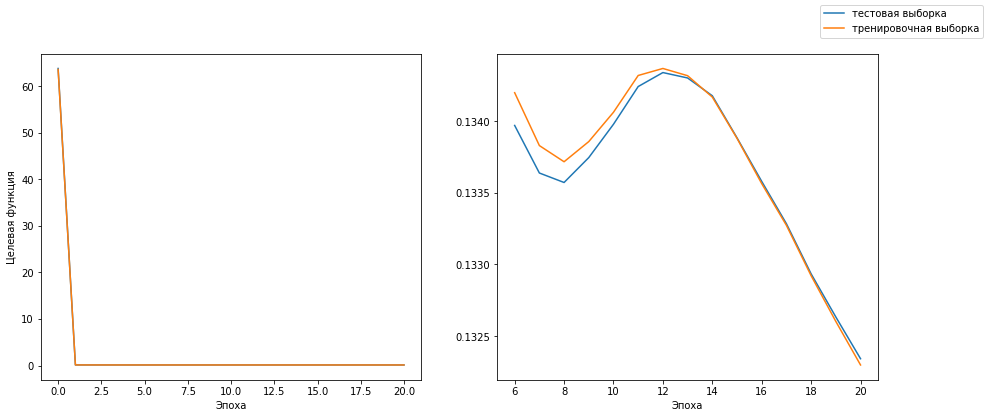

In [13]:
save_my_lc(
    lay1_trainer,
    curve_param = {'last_spes_show':15},
    plot_name = '20_epochs'
)

Доучиваем модель еще на 30 эпох

In [14]:
lay1_trainer.fit(
    train_data_loader, test_data_loader, epochs = 30
)

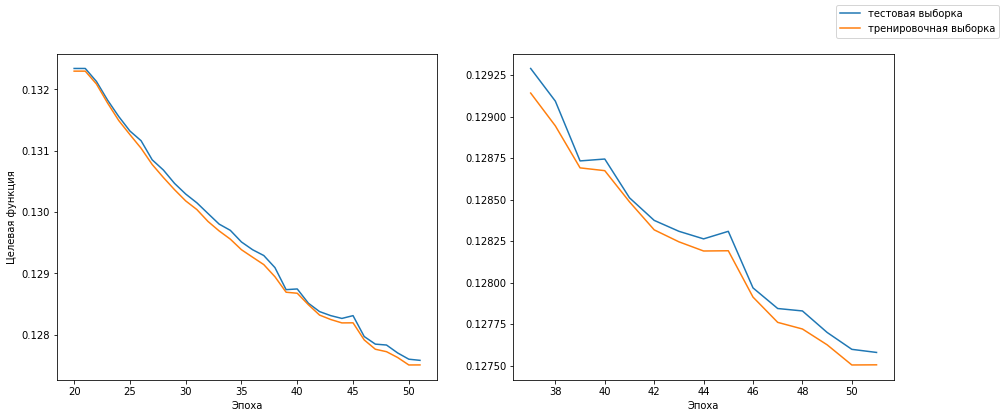

In [15]:
save_my_lc(
    lay1_trainer,
    curve_param = {
        'start_show': 20, 
        'last_spes_show': 15
    },
    plot_name = '50_epochs'
)

Продолжим обучение модели, но уже с меньшим learning rate

In [16]:
optimizer = optim.Adam(
    model_1lay.parameters(),
    lr = 0.0001
)
lay1_trainer.optimizer = optimizer

lay1_trainer.fit(
    train_data_loader, test_data_loader, epochs = 50
)

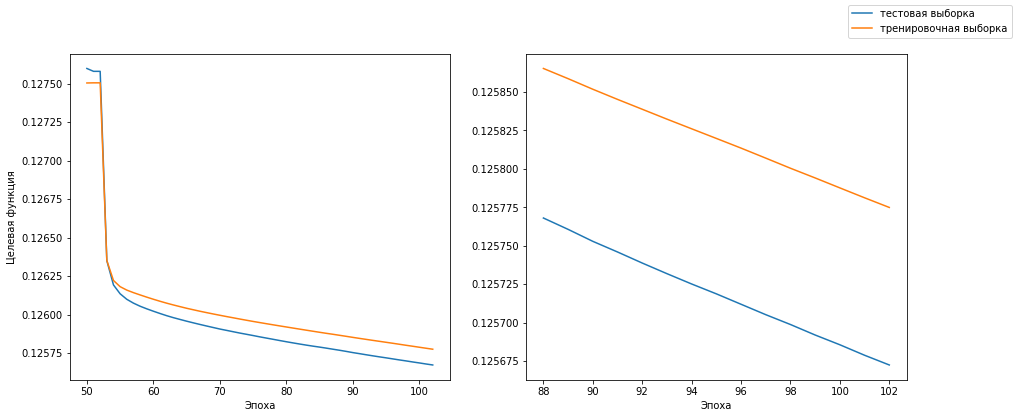

In [17]:
save_my_lc(
    lay1_trainer,
    curve_param = {
        'start_show': 50, 
        'last_spes_show': 15
    },
    plot_name = '50_epochs_50_plus_lr_0.0001'
)

Тут закончим с обучением "руками" - посмотрим какой AUC был получен

In [18]:
get_auc(lay1_trainer.best_model)

{'test': 0.7803867947973121, 'train': 0.7792185632488206}

## В целом путь намечен

Учить модель до критерия остановки, понижая lr, и затем контролировать AUC.

В этот раз кроме всего прочего нам понадобиться lc_scheduler

In [37]:
torch.manual_seed(0)
model_1lay = ResultNet([X.shape[1], X.shape[1]])

optimizer = optim.Adam(
    model_1lay.parameters(),
    lr = 0.01
)

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, gamma = 0.99,
    
)

lay1_trainer = model_trainer(
    model_1lay, optimizer, 
    loss_fn, lr_scheduler = lr_scheduler
)

lay1_trainer.fit(
    train_data_loader,
    test_data_loader,
    epochs = 1000,
    check_epoch = 20
)

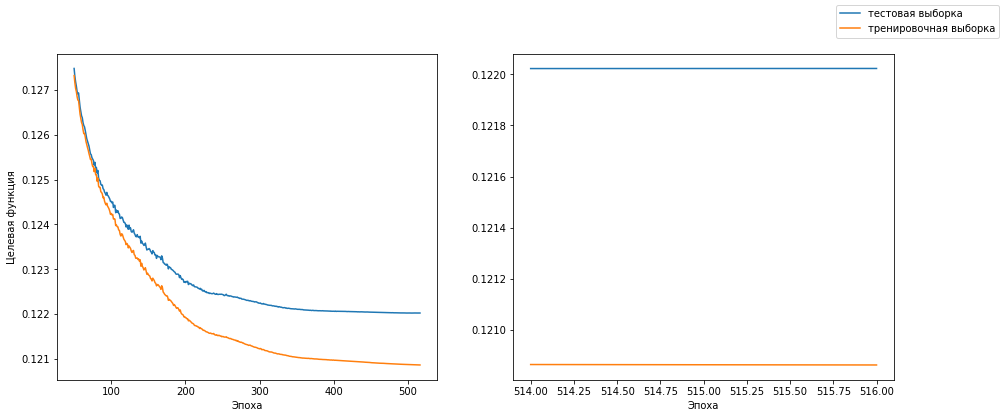

In [38]:
save_my_lc(
    lay1_trainer,
    curve_param = {
        'start_show': 50, 
        'last_spes_show': 3
    }
)

In [39]:
print('эпоха лучшей модели')
print(lay1_trainer.best_epoch)
get_auc(lay1_trainer.best_model)

эпоха лучшей модели
504


{'test': 0.799774948472894, 'train': 0.8038420172204928}

## Задокументируем попытки улучшения модели

Слишком быстрое уменьшение learning rate привело к тому, что модель престала доучиваться на определнный этапах (график too_fast_lr_decr_example.png). Это дало AUC <br>
{'test': 0.7563091889685637, 'train': 0.7545147015635103}<br>
Остановка по завершению эпох (300 эпох) lr 0.99<br>
{'test': 0.7987931657804059, 'train': 0.8024815784286833}

Подсление дейсвия позволили совсем немного улучшить нейронную сеть - но в целом это тоже достижение.

# Сохранение сети - и настроек данных

## Сеть

In [44]:
torch.save(lay1_trainer.best_model.state_dict(), 'model 1lay 113 neurons')

Посмотрим, как сетка, загрузиться 

In [47]:
model = ResultNet([113, 113])
model.load_state_dict(torch.load('model 1lay 113 neurons'))
get_auc(model)

{'test': 0.799774948472894, 'train': 0.8038420172204928}

## Данные

In [53]:
np.save("training_valid_data/X_train", X_train)
np.save("training_valid_data/y_train", y_train)
np.save("training_valid_data/X_test", X_test)
np.save("training_valid_data/y_test", y_test)